# SenNet + HOA - Hacking the Human Vasculature in 3D

## Importing Libraries

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import tifffile as tiff
import cv2
import torch.nn as nn
import albumentations as A
import numpy as np
import os
import time
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
!nvidia-smi

Fri Nov 21 15:42:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             28W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Sample Original Image & Label

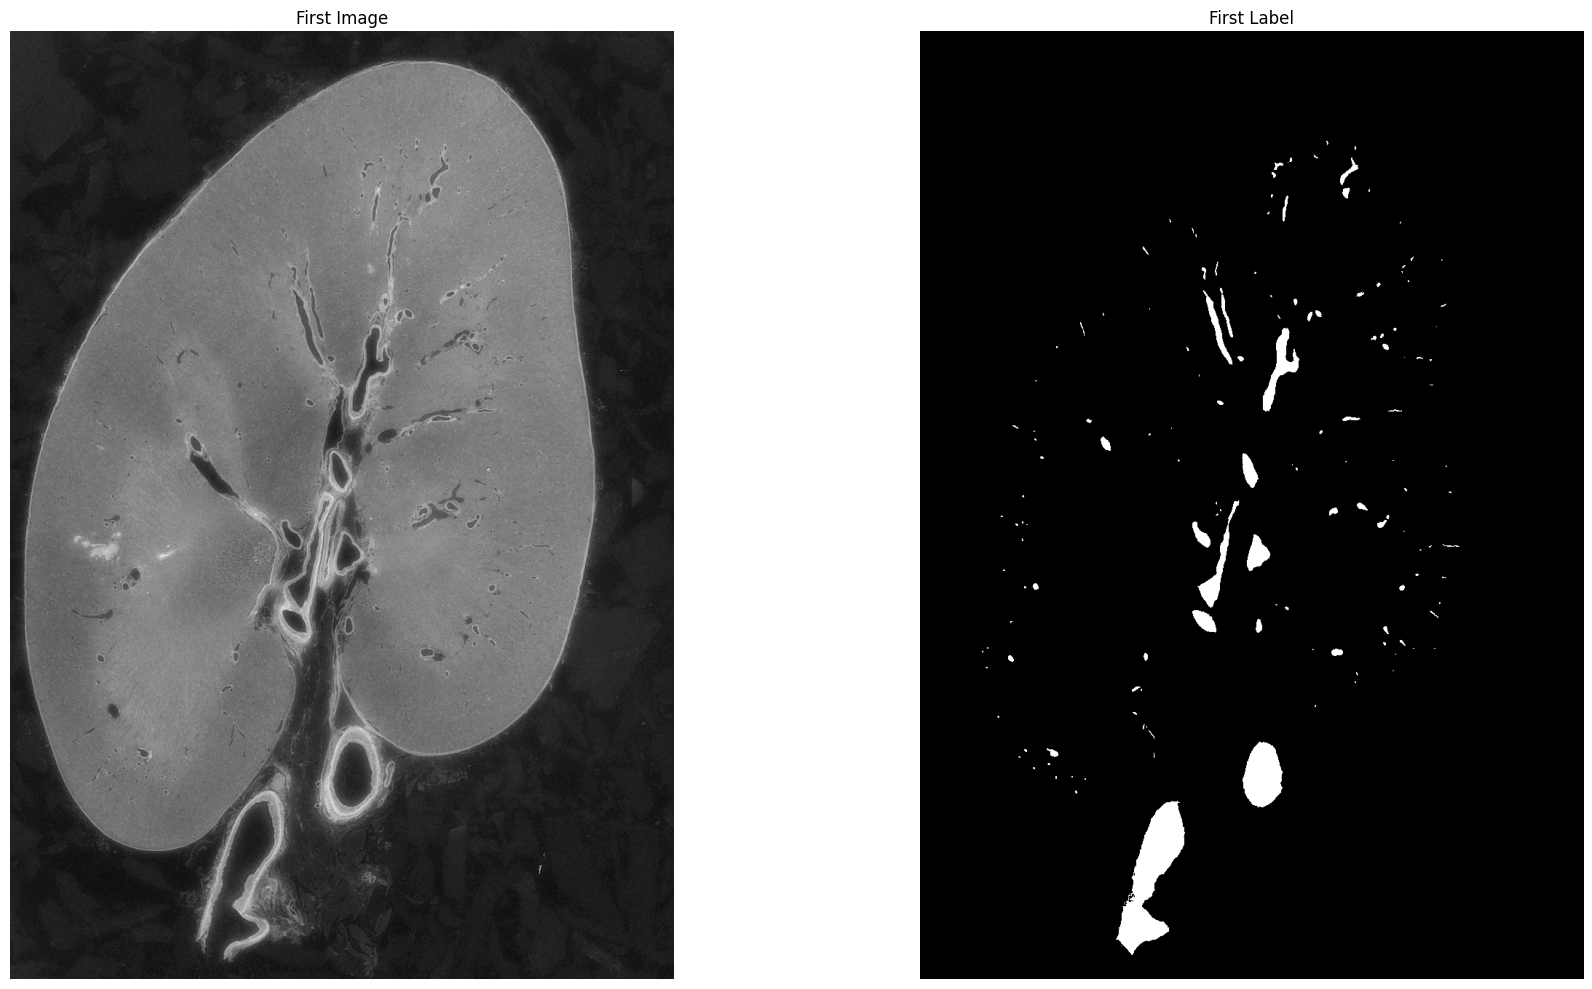

In [3]:
base_path = '/kaggle/input/blood-vessel-segmentation/train'  

dataset = 'kidney_1_dense'

images_path = os.path.join(base_path, dataset, 'images')
labels_path = os.path.join(base_path, dataset, 'labels')

image_files = sorted([os.path.join(images_path, f) for f in os.listdir(images_path) if f.endswith('.tif')])
label_files = sorted([os.path.join(labels_path, f) for f in os.listdir(labels_path) if f.endswith('.tif')])

def show_images(images,titles= None, cmap='gray'):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(20, 10))
    if not isinstance(axes, np.ndarray):
        axes = [axes]
    for idx, ax in enumerate(axes):
        ax.imshow(images[idx], cmap=cmap)
        if titles:
            ax.set_title(titles[idx])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

first_image = tiff.imread(image_files[981])
first_label = tiff.imread(label_files[981])

show_images([first_image, first_label], titles=['First Image', 'First Label'])

## Dataloader

In [4]:

class CustomDataset(Dataset):
    def __init__(self, image_files, mask_files, input_size=(256, 256), augmentation_transforms=None):
        self.image_files = image_files
        self.mask_files = mask_files
        self.input_size = input_size
        self.augmentation_transforms = augmentation_transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
       
        image_path = self.image_files[idx]
        mask_path = self.mask_files[idx]

        image = preprocess_image(image_path)
        mask = preprocess_mask(mask_path)

        if self.augmentation_transforms:
            image, mask = self.augmentation_transforms(image, mask)

        return image, mask

## Preprocessing of Images

In [5]:
def preprocess_image(path):
    
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = np.tile(img[...,None],[1, 1, 3]) 
    img = img.astype('float32') 
    mx = np.max(img)
    if mx:
        img/=mx 
        
    img = np.transpose(img, (2, 0, 1))
    img_ten = torch.tensor(img)
    return img_ten

## Preprocessing of Masks

In [6]:
def preprocess_mask(path):
    
    msk = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    msk = msk.astype('float32')
    msk/=255.0
    msk_ten = torch.tensor(msk)
    
    return msk_ten

## Augmentation

In [7]:
def augment_image(image, mask):
    
    image_np = image.permute(1, 2, 0).numpy()
    mask_np = mask.numpy()

    transform = A.Compose([
        A.Resize(256,256, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        A.RandomCrop(height=256, width=256, always_apply=True),
        A.RandomBrightness(p=1),
        A.OneOf(
            [
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
    
    ])

    augmented = transform(image=image_np, mask=mask_np)
    augmented_image, augmented_mask = augmented['image'], augmented['mask']

    augmented_image = torch.tensor(augmented_image, dtype=torch.float32).permute(2, 0, 1)
    augmented_mask = torch.tensor(augmented_mask, dtype=torch.float32)

    return augmented_image, augmented_mask

In [8]:
base_path = '/kaggle/input/blood-vessel-segmentation/train'  

dataset = 'kidney_1_dense'

images_path = os.path.join(base_path, dataset, 'images')
labels_path = os.path.join(base_path, dataset, 'labels')

image_files = sorted([os.path.join(images_path, f) for f in os.listdir(images_path) if f.endswith('.tif')])
label_files = sorted([os.path.join(labels_path, f) for f in os.listdir(labels_path) if f.endswith('.tif')])

## Splitting the Dataset

In [9]:
train_image_files, val_image_files, train_mask_files, val_mask_files = train_test_split(
    image_files, label_files, test_size=0.2, random_state=42)

In [10]:
train_dataset = CustomDataset(train_image_files, train_mask_files, augmentation_transforms=augment_image)
val_dataset = CustomDataset(val_image_files, val_mask_files, augmentation_transforms=augment_image)

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

## Augmented Batch_1 Images & Labels Viz.

/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


Batch 1
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])


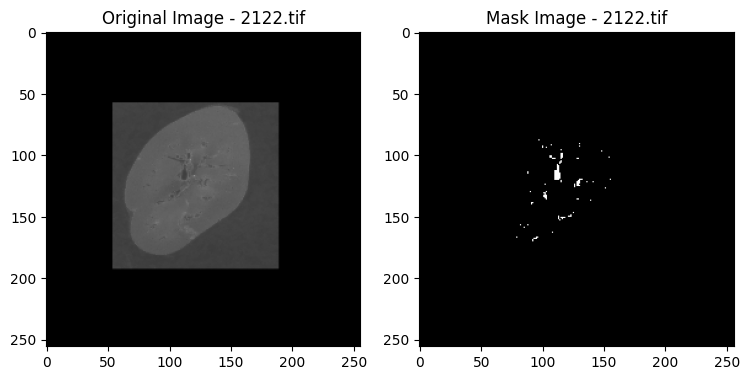

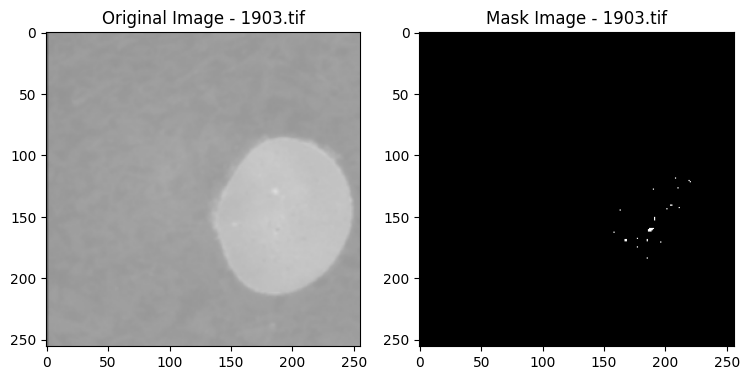

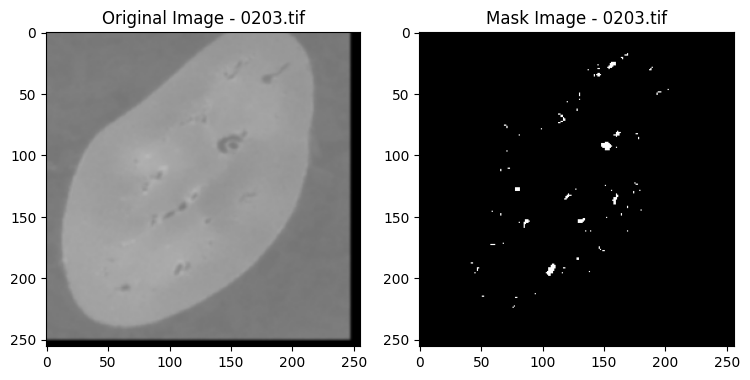

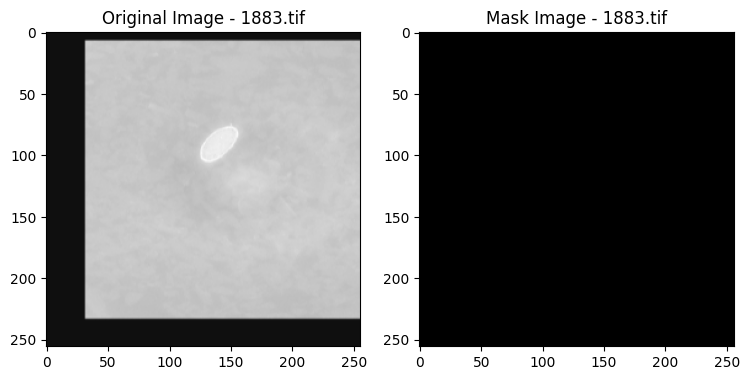

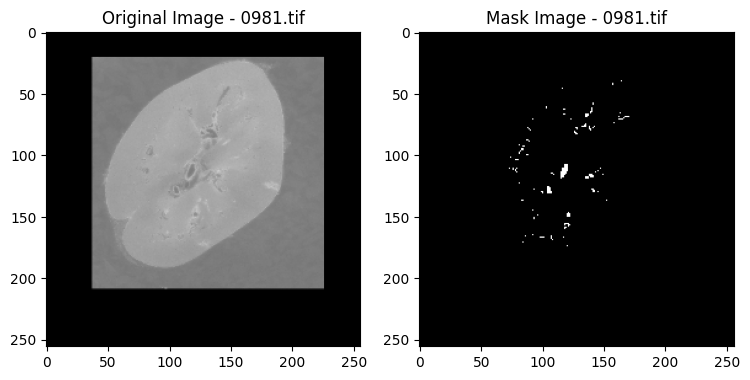

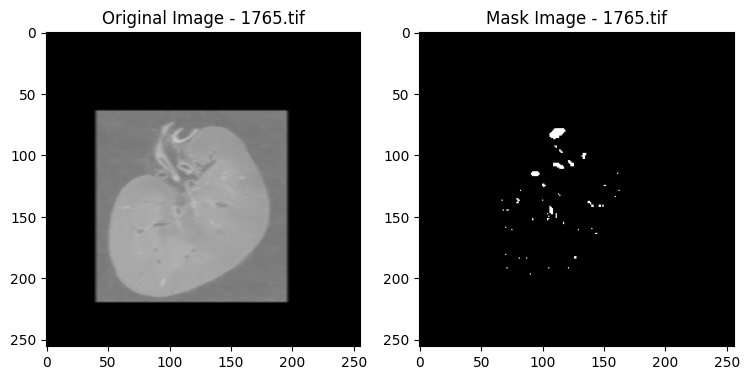

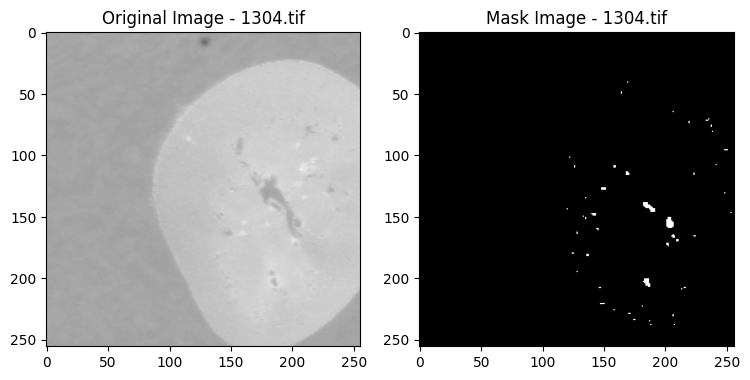

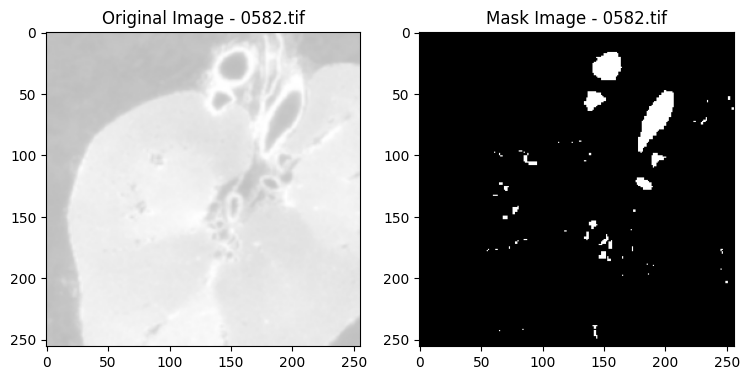

In [12]:
for batch_idx, (batch_images, batch_masks) in enumerate(train_dataloader):
    print("Batch", batch_idx + 1)
    print("Image batch shape:", batch_images.shape)
    print("Mask batch shape:", batch_masks.shape)
    
    for image, mask, image_path, mask_path in zip(batch_images, batch_masks, train_image_files, train_mask_files):
       
        image = image.permute((1, 2, 0)).numpy()*255.0
        image = image.astype('uint8')
        mask = (mask*255).numpy().astype('uint8')
        
        image_filename = os.path.basename(image_path)
        mask_filename = os.path.basename(mask_path)
        
        plt.figure(figsize=(15, 10))
        
        plt.subplot(2, 4, 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Original Image - {image_filename}")
        
        plt.subplot(2, 4, 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Mask Image - {mask_filename}")
        
        plt.tight_layout()
        plt.show()
    break

In [13]:
for batch_idx, (batch_images, batch_masks) in enumerate(train_dataloader):
    print("Batch", batch_idx + 1)
    print("Image batch shape:", batch_images.shape)
    print("Mask batch shape:", batch_masks.shape)

Batch 1
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 2
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 3
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 4
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 5
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 6
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 7
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 8
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 9
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 10
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])

In [14]:
for batch_idx, (batch_images, batch_masks) in enumerate(val_dataloader):
    print("Batch", batch_idx + 1)
    print("Image batch shape:", batch_images.shape)
    print("Mask batch shape:", batch_masks.shape)

Batch 1
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 2
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 3
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 4
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 5
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 6
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 7
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 8
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 9
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 10
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])

In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()
device

device(type='cuda')

## Attention U-Net architecture

One thing that is worth noticing, is that I had to add some black padding around images. It is because, I am using U-Net - like architecture with learnable visual attention blocks, and spatial dimensions of signal coming from skip connections and their corresponging feature maps must fit together. That is why the pictures after padding have size (592, 576) - they can be downsampled using max pooling 4 times (the dimensions are possible to divide by 4).

The picture that helps to understand the U-Net architecture is given below. It is a encoder-decoder architecture, that means that input image is first downsampled using max pooling. This process produces feature maps, that is semantic features coming from imput image. Then, the feature maps are upsampled again, to classify each pixel in the image. To make this process more accurate, authors of the architecture decided to use skip connections: signal from feature maps is combined with input image. It helps to decide precisely, which picture should be considered positive class (in this case: blood vessel) and which one should be marked as a background.

The picture's source is the U-Net paper.

![alt text](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

Recently, the field of Deep Learning is evolving extremely fast. New ideas and architectures are proposed frequently. One of them, that helped to improve NLP is attention. It is an idea that we can try to make our model focus on certain parts of the incoming signal (in case of text: sequences of words, in case of images: matrices with their digital representation). Computer Vision community, inspired by the work of their colleagues, have developed an idea of visual attention. For example the paper "Learn to pay attention" by Jetley et al describes the usage of learnable attention gate, that is additional blocks that gather signals from different layers of the network and learn where useful information from the image is. The prediction is made by concatenating the output from the attention blocks, and not by making use of the last layer of the network directly. The image from the article that describes the idea is given below: ![alt text](https://miro.medium.com/max/616/0*8r63L3yR66SVBgJR)

This idea was futher developed for semantic segmentation tasks by Oktay et al in the article "Attention U-Net: Learning Where to Look for the Pancreas". The difference is that attention blocks are now learning to filter signal from skip connections by estimating the information coming from them by comparing it with features from feature maps.
![alt text](https://miro.medium.com/max/780/1*PdYEf-OuUWkRsm2Lfrmy6A.png)


I decided to use this idea for my dataset, because it might work quite well, and also I would learn a lot.

In [16]:
class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class UpConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()

        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

# #OPTION 1 additive attention block (default):
# class AttentionBlock(nn.Module):
#     """Attention block with learnable parameters"""

#     def __init__(self, F_g, F_l, n_coefficients):
#         """
#         :param F_g: number of feature maps (channels) in previous layer
#         :param F_l: number of feature maps in corresponding encoder layer, transferred via skip connection
#         :param n_coefficients: number of learnable multi-dimensional attention coefficients
#         """
#         super(AttentionBlock, self).__init__()

#         self.W_gate = nn.Sequential(
#             nn.Conv2d(F_g, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
#             nn.BatchNorm2d(n_coefficients)
#         )

#         self.W_x = nn.Sequential(
#             nn.Conv2d(F_l, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
#             nn.BatchNorm2d(n_coefficients)
#         )

#         self.psi = nn.Sequential(
#             nn.Conv2d(n_coefficients, 1, kernel_size=1, stride=1, padding=0, bias=True),
#             nn.BatchNorm2d(1),
#             nn.Sigmoid()
#         )

#         self.relu = nn.ReLU(inplace=True)

#     def forward(self, gate, skip_connection):
#         """
#         :param gate: gating signal from previous layer
#         :param skip_connection: activation from corresponding encoder layer
#         :return: output activations
#         """
#         g1 = self.W_gate(gate)
#         x1 = self.W_x(skip_connection)
#         psi = self.relu(g1 + x1)
#         psi = self.psi(psi)
#         out = skip_connection * psi
#         return out
        
#OPTION 2 multiplicative attention block:
class AttentionBlock(nn.Module):
    """Attention block using multiplicative (dot-product) attention"""

    def __init__(self, F_g, F_l, n_coefficients):
        super(AttentionBlock, self).__init__()
        self.W_gate = nn.Sequential(
            nn.Conv2d(F_g, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, gate, skip_connection):
        # Project features to same dimension
        g1 = self.W_gate(gate)        # [B, n_coeff, H, W]
        x1 = self.W_x(skip_connection) # [B, n_coeff, H, W]

        # Multiplicative attention: element-wise multiplication
        psi = g1 * x1                 # [B, n_coeff, H, W]

        # Reduce channels to 1 using mean (or sum) across feature dimension
        psi = psi.mean(dim=1, keepdim=True)  # [B, 1, H, W]

        # Apply sigmoid to get attention mask
        psi = self.sigmoid(psi)

        # Apply mask to skip connection
        out = skip_connection * psi
        return out



class AttentionUNet(nn.Module):

    def __init__(self, img_ch=3, output_ch=1):
        super(AttentionUNet, self).__init__()

        self.MaxPool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = ConvBlock(img_ch, 64)
        self.Conv2 = ConvBlock(64, 128)
        self.Conv3 = ConvBlock(128, 256)
        self.Conv4 = ConvBlock(256, 512)
        self.Conv5 = ConvBlock(512, 1024)

        self.Up5 = UpConv(1024, 512)
        self.Att5 = AttentionBlock(F_g=512, F_l=512, n_coefficients=256)
        self.UpConv5 = ConvBlock(1024, 512)

        self.Up4 = UpConv(512, 256)
        self.Att4 = AttentionBlock(F_g=256, F_l=256, n_coefficients=128)
        self.UpConv4 = ConvBlock(512, 256)

        self.Up3 = UpConv(256, 128)
        self.Att3 = AttentionBlock(F_g=128, F_l=128, n_coefficients=64)
        self.UpConv3 = ConvBlock(256, 128)

        self.Up2 = UpConv(128, 64)
        self.Att2 = AttentionBlock(F_g=64, F_l=64, n_coefficients=32)
        self.UpConv2 = ConvBlock(128, 64)

        self.Conv = nn.Conv2d(64, output_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        """
        e : encoder layers
        d : decoder layers
        s : skip-connections from encoder layers to decoder layers
        """
        e1 = self.Conv1(x)

        e2 = self.MaxPool(e1)
        e2 = self.Conv2(e2)

        e3 = self.MaxPool(e2)
        e3 = self.Conv3(e3)

        e4 = self.MaxPool(e3)
        e4 = self.Conv4(e4)

        e5 = self.MaxPool(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)

        s4 = self.Att5(gate=d5, skip_connection=e4)
        d5 = torch.cat((s4, d5), dim=1) 
        d5 = self.UpConv5(d5)

        d4 = self.Up4(d5)
        s3 = self.Att4(gate=d4, skip_connection=e3)
        d4 = torch.cat((s3, d4), dim=1)
        d4 = self.UpConv4(d4)

        d3 = self.Up3(d4)
        s2 = self.Att3(gate=d3, skip_connection=e2)
        d3 = torch.cat((s2, d3), dim=1)
        d3 = self.UpConv3(d3)

        d2 = self.Up2(d3)
        s1 = self.Att2(gate=d2, skip_connection=e1)
        d2 = torch.cat((s1, d2), dim=1)
        d2 = self.UpConv2(d2)

        out = self.Conv(d2)

        return out

## Dice Coefficient

For segmenation task, Dice Coefficient is often used to measure performance of the models. I havn't used it as a loss function directly, because I read that training the model with such loss function is not always stable. I decided to use Focal loss, because it has this nice property that it focuses on imbalanced positive class. It was developed for object detection, but it can be used for segmenation too. In the dataset that I am using there is quite a big class imbalance - most of the pixels don't represent blood vessels.

The picture below help us understand Dice Coefficient intuitevely. It is a 2 * |AnB| / (|A| + |B|)

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1f/Intersection_of_sets_A_and_B.svg/1200px-Intersection_of_sets_A_and_B.svg.png)


In [17]:
def dice_coeff(prediction, target):

    mask = np.zeros_like(prediction)
    mask[prediction >= 0.5] = 1

    inter = np.sum(mask * target)
    union = np.sum(mask) + np.sum(target)
    epsilon = 1e-6
    result = np.mean(2 * inter / (union + epsilon))
    return result

## Focal Loss


The plot helped me understand the Focal Loss. It comes from the Focal Loss paper.
![alt text](https://miro.medium.com/max/1032/1*wLf0KMIzBsXPcxsN7yBrIA.png)

In [18]:
class FocalLoss(nn.modules.loss._WeightedLoss):

    def __init__(self, gamma=0, size_average=None, ignore_index=-100,
                 reduce=None, balance_param=1.0):
        super(FocalLoss, self).__init__(size_average)
        self.gamma = gamma
        self.size_average = size_average
        self.ignore_index = ignore_index
        self.balance_param = balance_param

    def forward(self, input, target):
        
        assert len(input.shape) == len(target.shape)
        assert input.size(0) == target.size(0)
        assert input.size(1) == target.size(1)

        logpt = - F.binary_cross_entropy_with_logits(input, target)
        pt = torch.exp(logpt)

        focal_loss = -((1 - pt) ** self.gamma) * logpt
        balanced_focal_loss = self.balance_param * focal_loss
        return balanced_focal_loss

In [19]:
dataloaders = {
    'training': train_dataloader,
    'test': val_dataloader
}

## Training and Testing Loop

In [20]:
def train_and_test(model, dataloaders, optimizer, criterion, num_epochs=100, show_images=False):
    since = time.time()
    best_loss = 1e10
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    fieldnames = ['epoch', 'training_loss', 'test_loss', 'training_dice_coeff', 'test_dice_coeff']
    train_epoch_losses = []
    test_epoch_losses = []
    for epoch in range(1, num_epochs + 1):

        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 10)
        
        batchsummary = {a: [0] for a in fieldnames}
        batch_train_loss = 0.0
        batch_test_loss = 0.0

        for phase in ['training', 'test']:
            if phase == 'training':
                model.train()  
            else:
                model.eval() 

            for sample in iter(dataloaders[phase]):

                if show_images:
                    grid_img = make_grid(sample[0])
                    grid_img = grid_img.permute(1, 2, 0)
                    plt.imshow(grid_img)
                    plt.show()

                inputs = sample[0].to(device)
                masks = sample[1].to(device)
                
                masks = masks.unsqueeze(1)
                
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'training'):
                    outputs = model(inputs)

                    loss = criterion(outputs, masks)

                    y_pred = outputs.data.cpu().numpy().ravel()
                    y_true = masks.data.cpu().numpy().ravel()

                    batchsummary[f'{phase}_dice_coeff'].append(dice_coeff(y_pred, y_true))

                    if phase == 'training':
                        loss.backward()
                        optimizer.step()

                        batch_train_loss += loss.item() * sample[0].size(0)

                    else:
                        batch_test_loss += loss.item() * sample[0].size(0)

            if phase == 'training':
                epoch_train_loss = batch_train_loss / len(dataloaders['training'])
                train_epoch_losses.append(epoch_train_loss)
            else:
                epoch_test_loss = batch_test_loss / len(dataloaders['test'])
                test_epoch_losses.append(epoch_test_loss)

            batchsummary['epoch'] = epoch
            
            print('{} Loss: {:.4f}'.format(phase, loss))

        best_loss = np.max(batchsummary['test_dice_coeff'])
        for field in fieldnames[3:]:
            batchsummary[field] = np.mean(batchsummary[field])
        print(
            f'\t\t\t train_dice_coeff: {batchsummary["training_dice_coeff"]}, test_dice_coeff: {batchsummary["test_dice_coeff"]}')

    print('Best dice coefficient: {:4f}'.format(best_loss))

    return model, train_epoch_losses, test_epoch_losses

In [21]:
epochs = 25

def train():
    model = AttentionUNet()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = FocalLoss(gamma=2)

    trained_model, train_epoch_losses, test_epoch_losses = train_and_test(model, dataloaders, optimizer, criterion, num_epochs=epochs)

    return trained_model, train_epoch_losses, test_epoch_losses


trained_model, train_epoch_losses, test_epoch_losses = train()

Epoch 1/25
----------
training Loss: 0.0088
test Loss: 0.0085
			 train_dice_coeff: 0.0004913946199672941, test_dice_coeff: 0.0
Epoch 2/25
----------
training Loss: 0.0048
test Loss: 0.0042
			 train_dice_coeff: 0.0, test_dice_coeff: 0.0
Epoch 3/25
----------
training Loss: 0.0029
test Loss: 0.0030
			 train_dice_coeff: 0.0, test_dice_coeff: 0.0
Epoch 4/25
----------
training Loss: 0.0025
test Loss: 0.0017
			 train_dice_coeff: 0.0, test_dice_coeff: 0.0
Epoch 5/25
----------
training Loss: 0.0014
test Loss: 0.0012
			 train_dice_coeff: 0.0, test_dice_coeff: 0.0
Epoch 6/25
----------
training Loss: 0.0009
test Loss: 0.0009
			 train_dice_coeff: 0.0, test_dice_coeff: 0.0
Epoch 7/25
----------
training Loss: 0.0009
test Loss: 0.0007
			 train_dice_coeff: 0.0, test_dice_coeff: 0.0
Epoch 8/25
----------
training Loss: 0.0007
test Loss: 0.0006
			 train_dice_coeff: 0.0, test_dice_coeff: 0.0
Epoch 9/25
----------
training Loss: 0.0004
test Loss: 0.0005
			 train_dice_coeff: 0.0, test_dice_coe

In [22]:
torch.save(trained_model.state_dict(), 'trained_model.pth')

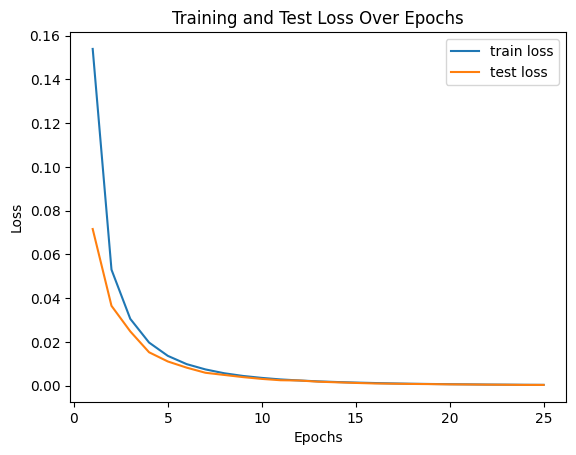

In [23]:
train_plot, = plt.plot(range(1, len(train_epoch_losses) + 1), train_epoch_losses, label='train loss')
test_plot, = plt.plot(range(1, len(test_epoch_losses) + 1), test_epoch_losses, label='test loss')
plt.legend(handles=[train_plot, test_plot])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.show()


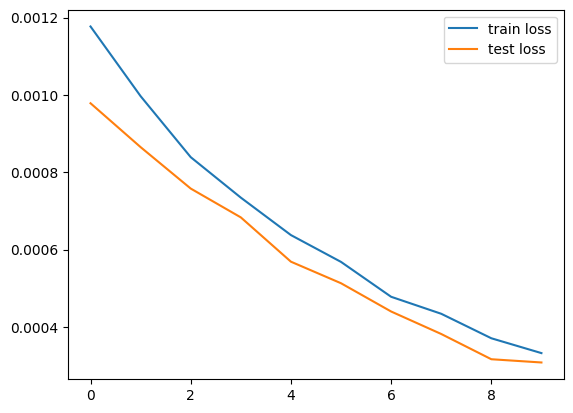

In [24]:
train_plot, = plt.plot(range(len(train_epoch_losses)-15), train_epoch_losses[15:], label='train loss')
test_plot, = plt.plot(range(len(test_epoch_losses)-15), test_epoch_losses[15:], label='test loss')
plt.legend(handles=[train_plot, test_plot])
plt.show()

In [25]:
# -------------------------
# Additive attention case 1
# -------------------------
training_log_1 = [
    {"epoch": 1, "train_loss": 0.0117, "test_loss": 0.0125, "train_dice": 0.0002311753, "test_dice": 0.0},
    {"epoch": 2, "train_loss": 0.0076, "test_loss": 0.0074, "train_dice": 0.0000025627, "test_dice": 0.0},
    {"epoch": 3, "train_loss": 0.0042, "test_loss": 0.0043, "train_dice": 0.0, "test_dice": 0.0},
    {"epoch": 4, "train_loss": 0.0029, "test_loss": 0.0030, "train_dice": 0.0, "test_dice": 0.0},
    {"epoch": 5, "train_loss": 0.0021, "test_loss": 0.0022, "train_dice": 0.0, "test_dice": 0.0},
    {"epoch": 6, "train_loss": 0.0014, "test_loss": 0.0014, "train_dice": 0.0, "test_dice": 0.0},
    {"epoch": 7, "train_loss": 0.0011, "test_loss": 0.0009, "train_dice": 0.0, "test_dice": 0.0},
    {"epoch": 8, "train_loss": 0.0008, "test_loss": 0.0007, "train_dice": 0.0, "test_dice": 0.0},
    {"epoch": 9, "train_loss": 0.0009, "test_loss": 0.0009, "train_dice": 0.0, "test_dice": 0.0},
    {"epoch": 10, "train_loss": 0.0008, "test_loss": 0.0006, "train_dice": 0.0, "test_dice": 0.0},
    {"epoch": 11, "train_loss": 0.0007, "test_loss": 0.0007, "train_dice": 0.0, "test_dice": 0.0},
    {"epoch": 12, "train_loss": 0.0003, "test_loss": 0.0005, "train_dice": 0.0, "test_dice": 0.0},
    {"epoch": 13, "train_loss": 0.0003, "test_loss": 0.0004, "train_dice": 0.0, "test_dice": 0.0},
    {"epoch": 14, "train_loss": 0.0002, "test_loss": 0.0003, "train_dice": 0.0, "test_dice": 0.0},
    {"epoch": 15, "train_loss": 0.0003, "test_loss": 0.0002, "train_dice": 0.00030867, "test_dice": 0.00115246},
    {"epoch": 16, "train_loss": 0.0002, "test_loss": 0.0002, "train_dice": 0.03078678, "test_dice": 0.05146220},
    {"epoch": 17, "train_loss": 0.0002, "test_loss": 0.0002, "train_dice": 0.20391435, "test_dice": 0.28939016},
    {"epoch": 18, "train_loss": 0.0001, "test_loss": 0.0001, "train_dice": 0.33585018, "test_dice": 0.37616633},
    {"epoch": 19, "train_loss": 0.0001, "test_loss": 0.0002, "train_dice": 0.42488387, "test_dice": 0.45048312},
    {"epoch": 20, "train_loss": 0.0001, "test_loss": 0.0001, "train_dice": 0.47735634, "test_dice": 0.49219045},
    {"epoch": 21, "train_loss": 0.0001, "test_loss": 0.0001, "train_dice": 0.49881425, "test_dice": 0.48438977},
    {"epoch": 22, "train_loss": 0.0001, "test_loss": 0.0001, "train_dice": 0.51555791, "test_dice": 0.51707192},
    {"epoch": 23, "train_loss": 0.0001, "test_loss": 0.0001, "train_dice": 0.51675538, "test_dice": 0.51194760},
    {"epoch": 24, "train_loss": 0.0001, "test_loss": 0.0001, "train_dice": 0.53920183, "test_dice": 0.50298280},
    {"epoch": 25, "train_loss": 0.0001, "test_loss": 0.0001, "train_dice": 0.53639502, "test_dice": 0.52554881}
]
best_dice_1 = 0.706281

# ------------------------------
# Multiplicative attention case 2
# ------------------------------
training_log_2 = [
    {"epoch": 1, "train_loss": 0.0153, "test_loss": 0.0145, "train_dice": 0.00019245, "test_dice": 0.0},
    {"epoch": 2, "train_loss": 0.0081, "test_loss": 0.0082, "train_dice": 0.0, "test_dice": 0.0},
    {"epoch": 3, "train_loss": 0.0048, "test_loss": 0.0049, "train_dice": 0.0, "test_dice": 0.0},
    {"epoch": 4, "train_loss": 0.0034, "test_loss": 0.0029, "train_dice": 0.0, "test_dice": 0.0},
    {"epoch": 5, "train_loss": 0.0023, "test_loss": 0.0019, "train_dice": 0.0, "test_dice": 0.0},
    {"epoch": 6, "train_loss": 0.0016, "test_loss": 0.0015, "train_dice": 0.0, "test_dice": 0.0},
    {"epoch": 7, "train_loss": 0.0015, "test_loss": 0.0013, "train_dice": 0.0, "test_dice": 0.0},
    {"epoch": 8, "train_loss": 0.0010, "test_loss": 0.0011, "train_dice": 0.0, "test_dice": 0.0},
    {"epoch": 9, "train_loss": 0.0007, "test_loss": 0.0008, "train_dice": 0.0, "test_dice": 0.0},
    {"epoch": 10, "train_loss": 0.0007, "test_loss": 0.0006, "train_dice": 0.0, "test_dice": 0.0},
    {"epoch": 11, "train_loss": 0.0006, "test_loss": 0.0005, "train_dice": 0.0, "test_dice": 0.0},
    {"epoch": 12, "train_loss": 0.0004, "test_loss": 0.0004, "train_dice": 0.0, "test_dice": 0.0},
    {"epoch": 13, "train_loss": 0.0004, "test_loss": 0.0004, "train_dice": 0.0, "test_dice": 0.0},
    {"epoch": 14, "train_loss": 0.0003, "test_loss": 0.0003, "train_dice": 0.0, "test_dice": 0.0},
    {"epoch": 15, "train_loss": 0.0003, "test_loss": 0.0004, "train_dice": 0.0, "test_dice": 0.0},
    {"epoch": 16, "train_loss": 0.0002, "test_loss": 0.0002, "train_dice": 0.0, "test_dice": 0.0},
    {"epoch": 17, "train_loss": 0.0002, "test_loss": 0.0002, "train_dice": 0.0, "test_dice": 0.0},
    {"epoch": 18, "train_loss": 0.0002, "test_loss": 0.0002, "train_dice": 0.00454182, "test_dice": 0.02278129},
    {"epoch": 19, "train_loss": 0.0002, "test_loss": 0.0001, "train_dice": 0.03744983, "test_dice": 0.08553801},
    {"epoch": 20, "train_loss": 0.0001, "test_loss": 0.0001, "train_dice": 0.14751024, "test_dice": 0.16799340},
    {"epoch": 21, "train_loss": 0.0001, "test_loss": 0.0001, "train_dice": 0.27940397, "test_dice": 0.22797661},
    {"epoch": 22, "train_loss": 0.0001, "test_loss": 0.0001, "train_dice": 0.35603721, "test_dice": 0.37073744},
    {"epoch": 23, "train_loss": 0.0001, "test_loss": 0.0001, "train_dice": 0.40771591, "test_dice": 0.37353069},
    {"epoch": 24, "train_loss": 0.0001, "test_loss": 0.0001, "train_dice": 0.45270332, "test_dice": 0.40456497},
    {"epoch": 25, "train_loss": 0.0001, "test_loss": 0.0001, "train_dice": 0.49200813, "test_dice": 0.41863624}
]
best_dice_2 = 0.683112



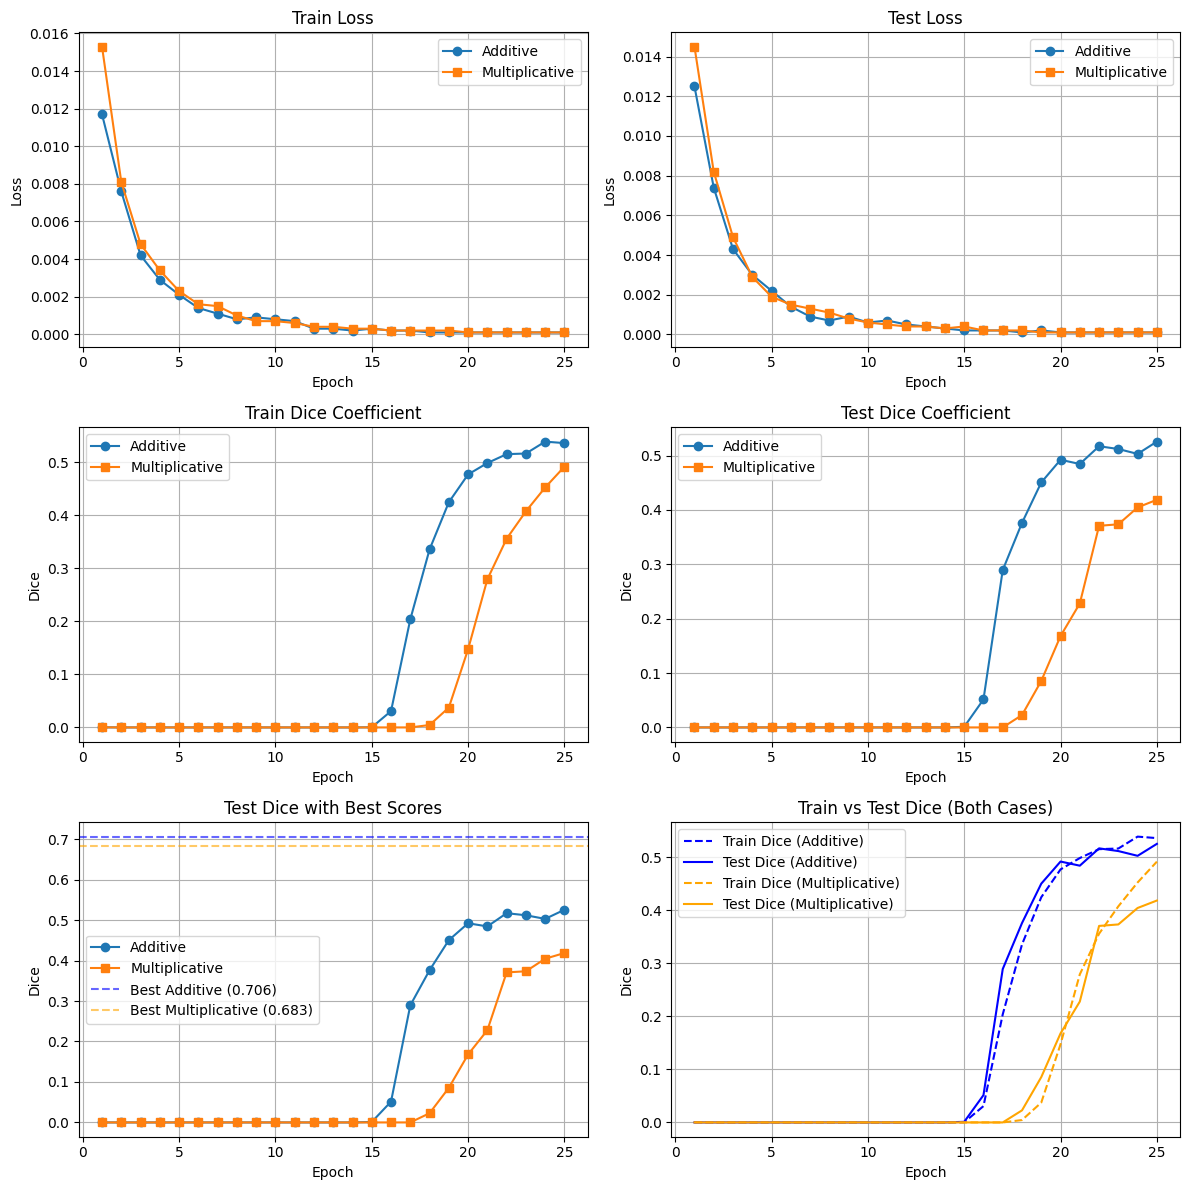

In [26]:
import matplotlib.pyplot as plt

# -------------------------
# Extract values
# -------------------------
epochs = [log["epoch"] for log in training_log_1]

train_loss_1 = [log["train_loss"] for log in training_log_1]
test_loss_1  = [log["test_loss"] for log in training_log_1]
train_dice_1 = [log["train_dice"] for log in training_log_1]
test_dice_1  = [log["test_dice"] for log in training_log_1]

train_loss_2 = [log["train_loss"] for log in training_log_2]
test_loss_2  = [log["test_loss"] for log in training_log_2]
train_dice_2 = [log["train_dice"] for log in training_log_2]
test_dice_2  = [log["test_dice"] for log in training_log_2]

# -------------------------
# Plot (6 subplots)
# -------------------------
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
axs = axs.ravel()

# 1. Train Loss
axs[0].plot(epochs, train_loss_1, label="Additive", marker="o")
axs[0].plot(epochs, train_loss_2, label="Multiplicative", marker="s")
axs[0].set_title("Train Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid(True)

# 2. Test Loss
axs[1].plot(epochs, test_loss_1, label="Additive", marker="o")
axs[1].plot(epochs, test_loss_2, label="Multiplicative", marker="s")
axs[1].set_title("Test Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()
axs[1].grid(True)

# 3. Train Dice
axs[2].plot(epochs, train_dice_1, label="Additive", marker="o")
axs[2].plot(epochs, train_dice_2, label="Multiplicative", marker="s")
axs[2].set_title("Train Dice Coefficient")
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("Dice")
axs[2].legend()
axs[2].grid(True)

# 4. Test Dice
axs[3].plot(epochs, test_dice_1, label="Additive", marker="o")
axs[3].plot(epochs, test_dice_2, label="Multiplicative", marker="s")
axs[3].set_title("Test Dice Coefficient")
axs[3].set_xlabel("Epoch")
axs[3].set_ylabel("Dice")
axs[3].legend()
axs[3].grid(True)

# 5. Test Dice + Best scores
axs[4].plot(epochs, test_dice_1, label="Additive", marker="o")
axs[4].plot(epochs, test_dice_2, label="Multiplicative", marker="s")
axs[4].axhline(best_dice_1, color="blue", linestyle="--", alpha=0.6, label=f"Best Additive ({best_dice_1:.3f})")
axs[4].axhline(best_dice_2, color="orange", linestyle="--", alpha=0.6, label=f"Best Multiplicative ({best_dice_2:.3f})")
axs[4].set_title("Test Dice with Best Scores")
axs[4].set_xlabel("Epoch")
axs[4].set_ylabel("Dice")
axs[4].legend()
axs[4].grid(True)

# 6. Train vs Test Dice per case
axs[5].plot(epochs, train_dice_1, label="Train Dice (Additive)", linestyle="--", color="blue")
axs[5].plot(epochs, test_dice_1, label="Test Dice (Additive)", color="blue")
axs[5].plot(epochs, train_dice_2, label="Train Dice (Multiplicative)", linestyle="--", color="orange")
axs[5].plot(epochs, test_dice_2, label="Test Dice (Multiplicative)", color="orange")
axs[5].set_title("Train vs Test Dice (Both Cases)")
axs[5].set_xlabel("Epoch")
axs[5].set_ylabel("Dice")
axs[5].legend()
axs[5].grid(True)

plt.tight_layout()
plt.show()

Additive attention is better because it can model non-linear interactions, handle different dimensions flexibly, and empirically achieves higher accuracy, at the cost of slightly higher computation. This principle is directly applied in Attention U-Net to improve segmentation performance.